In [8]:
!pip install -q texthero

In [9]:
! pip install -q scikit-multilearn

In [10]:
! pip install -q transformers

In [11]:
!pip install -q tensorflow-text

In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 7.0 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 92 kB 7.3 MB/s 
     |████████████████████████████████| 237 kB 43.6 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 352 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 12.8 MB/s 
     |████████████████████████████████| 636 kB 24.9 MB/s 


Data Exploration

In [12]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set(font_scale=1)
# Read data
df = pd.read_csv("/content/drive/MyDrive/ST Dataset/train.csv")

In [14]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 159571
Number of columns: 8


In [15]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
# checking for any null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

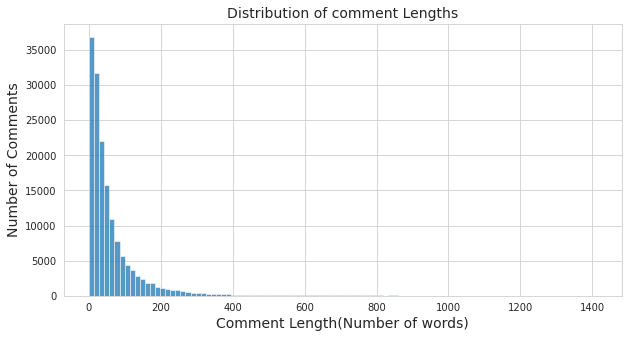

In [17]:
comment_lengths = [len(comment.split()) for comment in df["comment_text"]]
# plot the distribution of tweet lengths
plt.figure(figsize=(10,5))
sns.histplot(comment_lengths, bins=100);
plt.xlabel("Comment Length(Number of words)", fontsize=14);
plt.ylabel("Number of Comments", fontsize=14);
plt.title("Distribution of comment Lengths", fontsize=14);

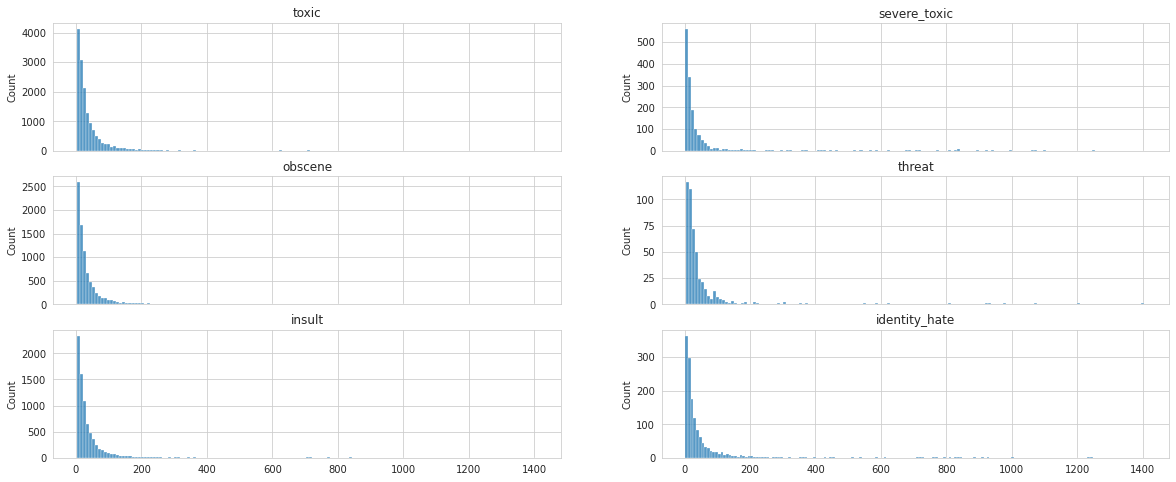

In [18]:
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, ax = plt.subplots(3, 2, figsize=(20,8), sharex=True)
axes =ax.ravel()
for i in range(6):
  comments = df.loc[df[labels[i]] == 1, :]
  comment_len = [len(comment.split()) for comment in comments["comment_text"]]
  sns.histplot(comment_len, ax=axes[i], bins = 150);
  axes[i].title.set_text(labels[i]);

Distribution of Labels

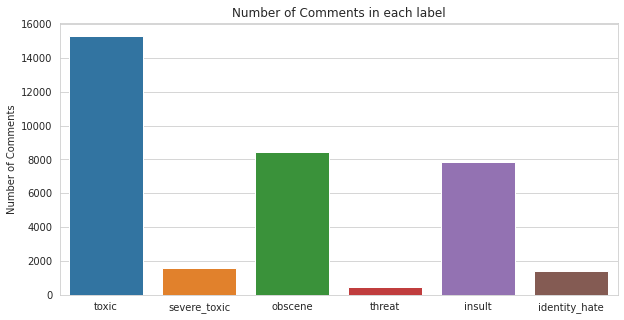

In [19]:
labels_count = df[labels].sum()
plt.figure(figsize = (10,5))
sns.barplot(x = labels_count.index,y = labels_count.values);
plt.title("Number of Comments in each label");
plt.ylabel("Number of Comments");

In [20]:
#check to see number of labels that a comment have.
multilabel_count = df[labels].sum(axis = 1).value_counts()
multilabel_count

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

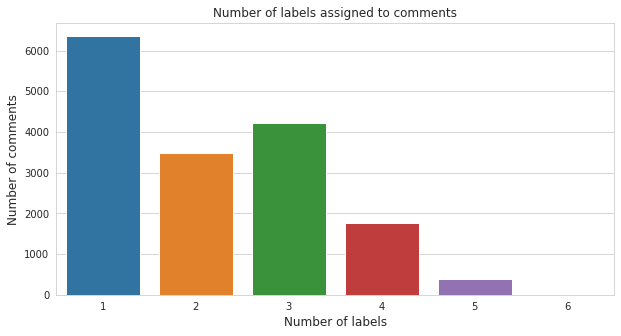

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x = multilabel_count.iloc[1:].index, y = multilabel_count.iloc[1:].values);
plt.title("Number of labels assigned to comments");
plt.xlabel("Number of labels", fontsize=12);
plt.ylabel("Number of comments",fontsize=12);

In [22]:
print(f'Number of comments with no any labels(clean tweet): {multilabel_count.iloc[0]}')
print(f'Percentage of comments with no any labels: {round(multilabel_count.iloc[0]/len(df) * 100,3)}%')
print("There are very high number, about 90% of the comments that do not have any toxic labels assigned to them.")

Number of comments with no any labels(clean tweet): 143346
Percentage of comments with no any labels: 89.832%
There are very high number, about 90% of the comments that do not have any toxic labels assigned to them.


In [23]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import re 
import texthero as hero
from texthero import preprocessing, wordcloud

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data Partition

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, random_state = 1)
# check the size of train and test data
print("Train:", train.shape)
print("Test:", test.shape)

Train: (111699, 8)
Test: (47872, 8)


In [28]:
clean_text_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_punctuation, # remove punctuation
               preprocessing.remove_digits, # remove numbers
               preprocessing.remove_diacritics,
               preprocessing.lowercase, # convert to lowercase
               preprocessing.remove_stopwords, # remove stopwords
               preprocessing.remove_whitespace , # remove any extra spaces
               preprocessing.stem # stemming of the words
               ]

In [29]:
# applying the processing pipeline
train['clean_text'] = hero.clean(train['comment_text'], clean_text_pipeline)
test['clean_text'] = hero.clean(test['comment_text'], clean_text_pipeline)

Vectorization - Bag Of Words

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
# separate features and labels
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

x_train = train.loc[:,'clean_text']
y_train = train[labels]

x_test = test.loc[:,'clean_text']
y_test = test[labels]
# tfdif vectorizer with 1 and 2 ngrams
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), 
                            min_df=2, 
                            max_features=1000)
tfidf_vec.fit(x_train)

TfidfVectorizer(max_features=1000, min_df=2, ngram_range=(1, 2))

In [31]:
# trasform train and test
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)
train_tfidf

<111699x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2005417 stored elements in Compressed Sparse Row format>

In [32]:
# extracted features
print(tfidf_vec.get_feature_names())

['abl', 'absolut', 'abus', 'academ', 'accept', 'access', 'accord', 'account', 'accur', 'accus', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'addit', 'address', 'admin', 'administr', 'admit', 'advertis', 'advic', 'afd', 'age', 'ago', 'agre', 'aid', 'air', 'album', 'align', 'alleg', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'altern', 'although', 'alway', 'america', 'american', 'among', 'amount', 'anim', 'anonym', 'anoth', 'answer', 'anti', 'anyon', 'anyth', 'anyway', 'apolog', 'appar', 'appear', 'appli', 'appreci', 'appropri', 'april', 'arab', 'archiv', 'area', 'argu', 'argument', 'around', 'art', 'articl', 'articl delet', 'articl talk', 'articl would', 'ask', 'ask question', 'ass', 'ass ass', 'assert', 'asshol', 'associ', 'assum', 'attack', 'attempt', 'attent', 'august', 'author', 'automat', 'avail', 'avoid', 'awar', 'award', 'away', 'back', 'background', 'background color', 'bad', 'ball', 'ball ball', 'ban', 'band', 'bark', 'barnstar', 'base', 'basic', 'batt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


DEEP LEARNING
LSTM

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout

In [34]:
# performing some text cleaning
clean_text_dl_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_diacritics,
               preprocessing.remove_punctuation,
               preprocessing.remove_digits,
               preprocessing.remove_whitespace  # remove any extra spaces
               ]
train_dl = hero.clean(train['comment_text'], clean_text_dl_pipeline)
test_dl = hero.clean(test['comment_text'], clean_text_dl_pipeline)

In [35]:
# tokenizing the text
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<unkown>')

tokenizer.fit_on_texts(train_dl.values)

In [36]:
# Number of unique words found
word_index = tokenizer.word_index
print(f'Number of unique words found: {len(word_index)}')

Number of unique words found: 139167


In [37]:
# transform train and test data to tokens
train_tokens = tokenizer.texts_to_sequences(train_dl.values)
test_tokens = tokenizer.texts_to_sequences(test_dl.values)

In [38]:
for seq in train_tokens[:5]:
  print(seq)

[446, 3820, 384, 55, 4721, 35, 3, 519, 7, 8, 446, 3820, 34, 2, 31, 3820, 1534, 20, 8, 279, 291]
[4, 20, 50, 238, 24, 2, 3169, 4980, 1371, 29, 11, 92, 8, 1930, 452, 6, 4722, 207, 1, 149, 66, 1, 50, 16, 1, 19, 913, 177, 4722, 452, 1241, 10, 2, 8508, 6, 759, 9, 4788, 3, 3250, 960, 406, 10, 45, 3169, 5324, 51, 15, 17, 759, 72, 566, 149, 1, 102, 15, 1, 3, 17, 759, 720, 8, 1930, 452, 51, 1657, 172, 10, 9, 15, 228, 6, 2, 2238, 452]
[4, 196, 362, 133, 14, 899, 362, 26, 4, 55, 362, 532, 11, 5, 10, 27, 8, 362, 249, 86, 586, 362, 5825, 9037, 39, 225]
[6167, 2, 1, 6167, 2, 1, 1, 1, 1, 1, 1, 6167, 2, 1, 9, 8, 790, 560, 887, 5, 2, 422, 1, 6, 2, 6167, 790, 560, 760, 1226, 35, 9531, 18, 103, 18, 12, 1384, 3662, 225, 3187, 8144, 5, 8, 2113, 609, 2, 118, 560, 27, 1226, 16, 885, 3, 454, 9531, 24, 8, 1, 3, 9532, 5536, 19, 9920, 887, 4340, 67, 12, 790, 4396, 148, 85, 6167, 46, 634, 52, 6, 2, 242, 19, 210, 428, 790, 560, 1155, 24, 69, 760, 346, 2694, 61, 96, 975, 3649, 12, 134, 1752, 38, 9531, 102, 8, 726, 

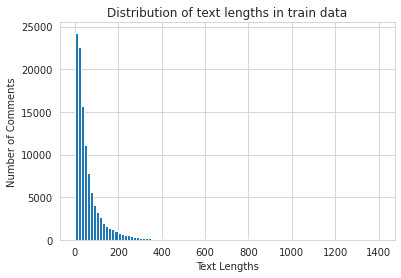

In [39]:
# visualize the distribution of text lenghts
text_lengths = [len(seq) for seq in train_tokens]
plt.hist(text_lengths, bins=100);
plt.title("Distribution of text lengths in train data");
plt.xlabel('Text Lengths');
plt.ylabel("Number of Comments");

In [40]:
print(f'Mean length of text sequences: {np.mean(text_lengths)}')
print("We see majority of comments have text lenghts of around 200. So, we will pad our texts to the length of 200.")

Mean length of text sequences: 67.6711071719532
We see majority of comments have text lenghts of around 200. So, we will pad our texts to the length of 200.


In [41]:
PAD_LENGTH = 200
train_padded = pad_sequences(train_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')
test_padded = pad_sequences(test_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')

In [42]:
# create the model
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units= 50, dropout=0.4, return_sequences=False))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000300   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 512)               26112     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

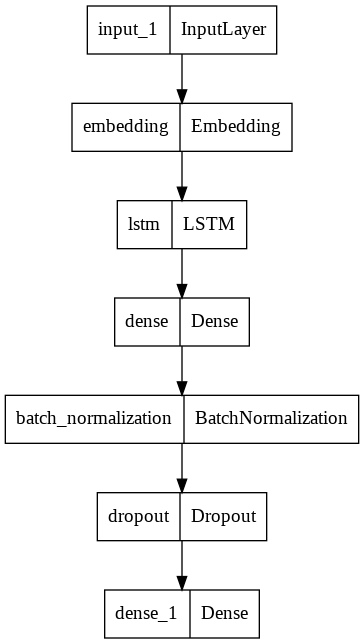

In [43]:
tf.keras.utils.plot_model(model,show_layer_names=True)

In [ ]:
# compile the model
model.compile(tf.keras.optimizers.Adam(lr = 5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_lstm_model', save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

In [ ]:
# fit the model
lstm_history = model.fit(train_padded, y_train,
                         validation_data = (test_padded, y_test),
                         batch_size=32,
                         epochs = 2, callbacks = callbacks)

Epoch 1/2
3491/3491 [==============================] - ETA: 0s - loss: 0.0618 - binary_accuracy: 0.9790 - auc: 0.9412WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbbabc17290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


INFO:tensorflow:Assets written to: best_lstm_model/assets


INFO:tensorflow:Assets written to: best_lstm_model/assets


3491/3491 [==============================] - 1059s 303ms/step - loss: 0.0618 - binary_accuracy: 0.9790 - auc: 0.9412 - val_loss: 0.0542 - val_binary_accuracy: 0.9808 - val_auc: 0.9594 - lr: 5.0000e-04
Epoch 2/2
3491/3491 [==============================] - ETA: 0s - loss: 0.0528 - binary_accuracy: 0.9809 - auc: 0.9622

INFO:tensorflow:Assets written to: best_lstm_model/assets


INFO:tensorflow:Assets written to: best_lstm_model/assets


3491/3491 [==============================] - 1033s 296ms/step - loss: 0.0528 - binary_accuracy: 0.9809 - auc: 0.9622 - val_loss: 0.0535 - val_binary_accuracy: 0.9810 - val_auc: 0.9598 - lr: 5.0000e-04


Here we see that already after 2 epochs, the model is showing overfitting behavior, where train loss and auc improves, but for validation data there is no improvement.

In [ ]:
best_model = tf.keras.models.load_model('best_lstm_model')

In [ ]:
# evaluation
loss, accuracy, auc = best_model.evaluate(test_padded, y_test)

print(f'Accuracy : {np.round(accuracy,4)}')
print(f'Auc : {np.round(auc,4)}')
print(f'Logloss : {np.round(loss,4)}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1496/1496 [==============================] - 80s 52ms/step - loss: 0.0535 - binary_accuracy: 0.9810 - auc: 0.9598
Accuracy : 0.981
Auc : 0.9598
Logloss : 0.0535


The results from the LSTM gave improvements over Logistic Regression model for the metrics Accuracy and logloss, but the AUC score is similar. So, with improvement for two of the metrics, we can still consider LSTM to be performing better than the Logistic Regression Model.

Now, for our final model, we will apply transfer learning with BERT, which has been the state of the art model for NLP task at the moment.

In [ ]:
lstm_model = tf.keras.models.load_model('best_lstm_model')

In [ ]:
sub_test = pd.read_csv('/content/drive/MyDrive/ST Dataset/test.csv')
sub_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
# cleaning text and vectorizing
sub_test['clean_text'] = hero.clean(sub_test['comment_text'],clean_text_pipeline)
sub_test_vect = tfidf_vec.transform(sub_test['clean_text'])

In [ ]:
# function to save submission file
labels =['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def create_submission_file(test_id, predictions, labels, filename):
  pred_df = pd.DataFrame(predictions, columns=labels)
  final_sub =pd.concat([test_id,sub_test,pred_df], axis = 1)
  final_sub.to_csv(filename, index=False)
  print("Output Created")

In [ ]:
lstm_sub = hero.clean(sub_test['comment_text'], clean_text_dl_pipeline)

In [ ]:
# tokenizing and paddaing
lstm_tokens = tokenizer.texts_to_sequences(lstm_sub)
lstm_padded = pad_sequences(lstm_tokens, maxlen=PAD_LENGTH,padding='post', truncating='post')

In [ ]:
# make predictions with lstm
lstm_pred = lstm_model.predict(lstm_padded)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# create submission file
create_submission_file(test_id=sub_test['id'], labels = labels, predictions=lstm_pred,
                       filename = "lstm_results.csv")

Output Created
